STEP1. TOI Table Validation and Evaluation by Disposition Category

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Times New Roman"]})

# First RF model

In [4]:

# Load the TOI data file
toi_data = pd.read_csv('output_data/TOI_2025.08.02_05.03.17_final.csv')

# Select prediction features
features = ['pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_eqt', 'pl_insol', 'st_teff', 'st_logg', 'st_rad', 'fe_h']
koi_features = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet']
data_pred = toi_data[features].rename(columns={f: k for f, k in zip(features, koi_features)})

# Drop rows with missing data in the selected features
data_pred_cleaned = data_pred.dropna()

# Update the original DataFrame to reflect the dropped rows
toi_data_cleaned = toi_data.loc[data_pred_cleaned.index]

# Load the pre-fitted scaler and scale the features
ss = joblib.load('output_data/scaler_ksmet.sav')
data_pred_scaled = pd.DataFrame(ss.transform(data_pred_cleaned), columns=koi_features)

# Load the pre-trained Random Forest model
loaded_model = joblib.load('output_data/best_model.pkl')

# Make predictions
predictions = loaded_model.predict(data_pred_scaled)

# Reset index of cleaned DataFrame and add predictions
toi_data_cleaned = toi_data_cleaned.reset_index(drop=True)
toi_data_cleaned['Prediction'] = predictions
print(f"Number of predicted positives (1): {np.sum(predictions == 1)}")
print(f"Number of predicted negatives (0): {np.sum(predictions == 0)}")

# Save the results to a new CSV file
toi_data_cleaned.to_csv('output_data/TOI_2025.08.02_05.03.17_final_predicted.csv', index=False)



Number of predicted positives (1): 3550
Number of predicted negatives (0): 1632


In [5]:
# print constituents of each category in tfopwg_disp
print("Constituents of each category in 'tfopwg_disp':")
for category in ['CP', 'KP', 'FP', 'FA']:
    count = len(toi_data_cleaned[toi_data_cleaned['tfopwg_disp'] == category])
    print(f"{category}: {count} entries")

Constituents of each category in 'tfopwg_disp':
CP: 601 entries
KP: 522 entries
FP: 632 entries
FA: 48 entries


In [6]:
toi_data_cleaned['tfopwg_disp'].value_counts()

tfopwg_disp
PC     3186
FP      632
CP      601
KP      522
APC     193
FA       48
Name: count, dtype: int64

In [7]:
y_pred = toi_data_cleaned['Prediction']
y_pred

0       0
1       0
2       1
3       1
4       0
       ..
5177    0
5178    1
5179    1
5180    0
5181    0
Name: Prediction, Length: 5182, dtype: int64

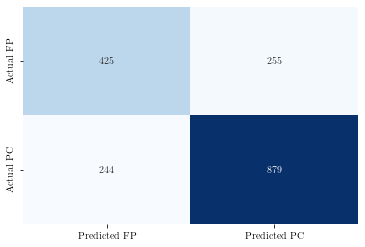

True Negatives (TN): 425
False Positives (FP): 255
False Negatives (FN): 244
True Positives (TP): 879
Recall: 0.7827
Precision: 0.7751
F1 Score: 0.7789
Accuracy: 0.7232


In [8]:
y_true = toi_data_cleaned['tfopwg_disp'].map({'CP': 1, 'KP': 1, 'FP': 0, 'FA': 0}).dropna().astype(int)
y_pred = toi_data_cleaned.loc[y_true.index, 'Prediction'].astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted FP', 'Predicted PC'], yticklabels=['Actual FP', 'Actual PC'], cbar=False)
plt.savefig('figures/confusion_matrix.pdf', bbox_inches='tight')
plt.show()

# print confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# print classification metrics
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


In [9]:
# breakdown of predictions by category
summary_table = pd.DataFrame(index=['CP', 'KP', 'FP', 'FA', 'PC', 'APC'],
                            columns=['Total TOIs', 'Predicted 1', 'Predicted 0', 'Accuracy %'])
for category in summary_table.index:
    category_data = toi_data_cleaned[toi_data_cleaned['tfopwg_disp'] == category]
    total = len(category_data)
    pred_1 = np.sum(category_data['Prediction'] == 1)
    pred_0 = np.sum(category_data['Prediction'] == 0)
    if category in ['FP', 'FA']:
        accuracy_cat = (pred_0 / total * 100) if total > 0 else 0
    else:
        accuracy_cat = (pred_1 / total * 100) if total > 0 else 0
    summary_table.loc[category] = [total, pred_1, pred_0, f"{accuracy_cat:.2f}"]
print("\nSummary Table:")
print(summary_table)



Summary Table:
    Total TOIs Predicted 1 Predicted 0 Accuracy %
CP         601         523          78      87.02
KP         522         356         166      68.20
FP         632         225         407      64.40
FA          48          30          18      37.50
PC        3186        2341         845      73.48
APC        193          75         118      38.86


Number of CP/KP predicted as 0: 244
Number of CP/KP predicted as 1: 879
Number of FP/FA predicted as 1: 255
Number of FP/FA predicted as 0: 425


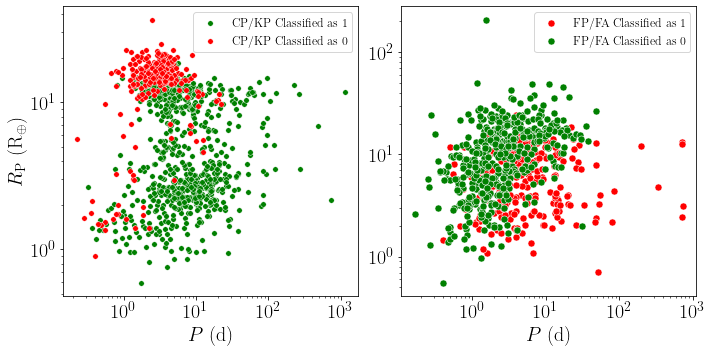

In [10]:
# breakdown of CP, KP, FP, FA show the distribution of Predicted 0 for CP and KP, Predicted 1 for FP and FA
tn_cp_kp = toi_data_cleaned[(toi_data_cleaned['tfopwg_disp'].isin(['CP', 'KP'])) & (toi_data_cleaned['Prediction'] == 0)]
tp_cp_kp = toi_data_cleaned[(toi_data_cleaned['tfopwg_disp'].isin(['CP', 'KP'])) & (toi_data_cleaned['Prediction'] == 1)]
fp_fp_fa = toi_data_cleaned[(toi_data_cleaned['tfopwg_disp'].isin(['FP', 'FA'])) & (toi_data_cleaned['Prediction'] == 1)]
tn_fp_fa = toi_data_cleaned[(toi_data_cleaned['tfopwg_disp'].isin(['FP', 'FA'])) & (toi_data_cleaned['Prediction'] == 0)]
print(f"Number of CP/KP predicted as 0: {len(tn_cp_kp)}")
print(f"Number of CP/KP predicted as 1: {len(tp_cp_kp)}")
print(f"Number of FP/FA predicted as 1: {len(fp_fp_fa)}")
print(f"Number of FP/FA predicted as 0: {len(tn_fp_fa)}")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=tp_cp_kp, x='pl_orbper', y='pl_rade', marker='o', s=30, color='green', label='CP/KP Classified as 1', ax=axes[0])
sns.scatterplot(data=tn_cp_kp, x='pl_orbper', y='pl_rade', marker='o', s=30, color='red', label='CP/KP Classified as 0', ax=axes[0])
sns.scatterplot(data=fp_fp_fa, x='pl_orbper', y='pl_rade', marker='o', s=50, color='red', label='FP/FA Classified as 1', ax=axes[1])
sns.scatterplot(data=tn_fp_fa, x='pl_orbper', y='pl_rade', marker='o', s=50, color='green', label='FP/FA Classified as 0', ax=axes[1])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$P$ (d)', fontsize=20)
axes[0].set_ylabel(r'$R_\mathrm{P}$ (R$_\oplus$)', fontsize=20)
axes[0].legend(fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel(r'$P$ (d)', fontsize=20)
# do not show ylabel for the right panel, even not the default column name
axes[1].set_ylabel('')
axes[1].legend(fontsize=12)
plt.tight_layout()
plt.savefig('figures/RF_model_classification_distribution.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# create a figure caption
fig_caption = """
Figure: Distribution of TOIs classified by the Random Forest model.
Left panel: Confirmed Planets (CP) and Known Planets (KP) classified as 1 (green) and 0 (red).
Right panel: False Positives (FP) and False Alarms (FA) classified as 1 (red) and 0 (green).

## t-SNE Visualization of Feature Space

Computing t-SNE embedding (this may take a minute)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1803 samples in 0.001s...
[t-SNE] Computed neighbors for 1803 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1803
[t-SNE] Computed conditional probabilities for sample 1803 / 1803
[t-SNE] Mean sigma: 0.334399
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.359573
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.359573
[t-SNE] KL divergence after 1000 iterations: 1.052483
[t-SNE] KL divergence after 1000 iterations: 1.052483


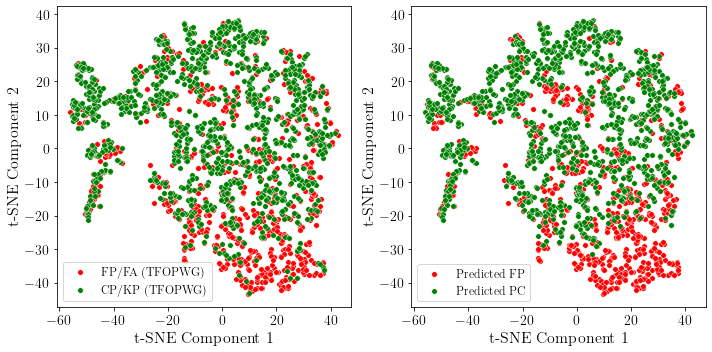


t-SNE embedding completed.
Number of Planet Candidates (CP/KP): 1123
Number of False Positives (FP/FA): 680


In [24]:
from sklearn.manifold import TSNE

# Prepare data for t-SNE
# Use the scaled features and create labels based on disposition
y_true_tsne = toi_data_cleaned['tfopwg_disp'].map({'CP': 1, 'KP': 1, 'FP': 0, 'FA': 0})
valid_indices = y_true_tsne.notna()
X_tsne = data_pred_scaled[valid_indices]
y_tsne = y_true_tsne[valid_indices].astype(int)

# Apply t-SNE
print("Computing t-SNE embedding (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
X_tsne_embedded = tsne.fit_transform(X_tsne)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Prepare DataFrames for seaborn plotting
# Left panel: Actual classification
tsne_df_actual = pd.DataFrame({
    'Component 1': X_tsne_embedded[:, 0],
    'Component 2': X_tsne_embedded[:, 1],
    'Class': ['FP/FA' if y == 0 else 'CP/KP' for y in y_tsne]
})

# Right panel: RF predictions
y_pred_tsne = toi_data_cleaned.loc[valid_indices, 'Prediction'].astype(int)
tsne_df_pred = pd.DataFrame({
    'Component 1': X_tsne_embedded[:, 0],
    'Component 2': X_tsne_embedded[:, 1],
    'Class': ['Predicted FP' if y == 0 else 'Predicted PC' for y in y_pred_tsne]
})

# Left panel: Color by actual class
sns.scatterplot(data=tsne_df_actual[tsne_df_actual['Class'] == 'FP/FA'], 
                x='Component 1', y='Component 2', marker='o', s=30, 
                color='red', label='FP/FA (TFOPWG)', ax=axes[0])
sns.scatterplot(data=tsne_df_actual[tsne_df_actual['Class'] == 'CP/KP'], 
                x='Component 1', y='Component 2', marker='o', s=30, 
                color='green', label='CP/KP (TFOPWG)', ax=axes[0])
axes[0].set_xlabel('t-SNE Component 1', fontsize=16)
axes[0].set_ylabel('t-SNE Component 2', fontsize=16)
axes[0].legend(fontsize=12, loc='best')
axes[0].tick_params(axis='both', which='major', labelsize=14)

# Right panel: Color by RF prediction
sns.scatterplot(data=tsne_df_pred[tsne_df_pred['Class'] == 'Predicted FP'], 
                x='Component 1', y='Component 2', marker='o', s=30, 
                color='red', label='Predicted FP', ax=axes[1])
sns.scatterplot(data=tsne_df_pred[tsne_df_pred['Class'] == 'Predicted PC'], 
                x='Component 1', y='Component 2', marker='o', s=30, 
                color='green', label='Predicted PC', ax=axes[1])
axes[1].set_xlabel('t-SNE Component 1', fontsize=16)
axes[1].set_ylabel('t-SNE Component 2', fontsize=16)
axes[1].legend(fontsize=12, loc='best')
axes[1].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig('figures/tsne_visualization_TOI.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"\nt-SNE embedding completed.")
print(f"Number of Planet Candidates (CP/KP): {np.sum(y_tsne == 1)}")
print(f"Number of False Positives (FP/FA): {np.sum(y_tsne == 0)}")

In [ ]:
# Create figure caption
tsne_caption = """
Figure: t-SNE visualization of TOI classifications in 10-dimensional feature space.

Left panel: TFOPWG disposition classifications (CP/KP in green, FP/FA in red).
Right panel: Random Forest model predictions (predicted planet candidates in green, predicted false positives in red).

t-SNE (t-Distributed Stochastic Neighbor Embedding) reduces the 10 standardized features 
(orbital period, transit duration, transit depth, planet radius, equilibrium temperature, 
insolation, stellar effective temperature, surface gravity, stellar radius, and metallicity) 
to 2 dimensions while preserving local neighborhood structure.

Key observations:
- The visualization reveals substantial overlap between planet candidates (CP/KP) and false 
  positives (FP/FA) in the 10-dimensional feature space, indicating that these populations 
  share similar transit and stellar characteristics
- The degree of overlap reflects the inherent difficulty in distinguishing these classes based 
  solely on the 10 features, suggesting that some TOIs are genuinely ambiguous and may require 
  additional observational data (e.g., high-resolution imaging, radial velocity measurements) 
  for definitive classification
- The similarity between left (TFOPWG) and right (RF predictions) panels demonstrates that the 
  Random Forest model successfully captures the underlying structure of the data
- Misclassifications occur primarily in overlapping regions where the features do not provide 
  sufficient discrimination, rather than being systematically distributed
- Unlike PCA (which captures 99.96% variance in 2 linear components), t-SNE reveals non-linear 
  clustering patterns and local neighborhood structure in the feature space
"""
print(tsne_caption)

# Now do the same for transformer nn

In [86]:
import tensorflow as tf
best_model_tnn = tf.keras.models.load_model('models/NNmodel.h5')

x_test = tf.expand_dims(data_pred_scaled, axis=-1)  
y_pred_nn = (best_model_tnn.predict(x_test) > 0.5).astype("int32")

162/162 [==============================] - 0s 670us/step


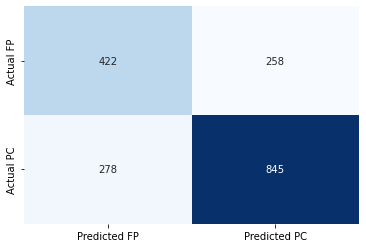

True Negatives (TN): 422
False Positives (FP): 258
False Negatives (FN): 278
True Positives (TP): 845
Recall: 0.7524
Precision: 0.7661
F1 Score: 0.7592
Accuracy: 0.7027


In [87]:
toi_data_cleaned['Prediction_NN'] = y_pred_nn
y_true = toi_data_cleaned['tfopwg_disp'].map({'CP': 1, 'KP': 1, 'FP': 0, 'FA': 0}).dropna().astype(int)
y_pred = toi_data_cleaned.loc[y_true.index, 'Prediction_NN'].astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted FP', 'Predicted PC'], yticklabels=['Actual FP', 'Actual PC'], cbar=False)
plt.savefig('figures/confusion_matrix.pdf', bbox_inches='tight')
plt.show()

# print confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# print classification metrics
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

In [88]:
# breakdown of predictions by category
summary_table_nn = pd.DataFrame(index=['CP', 'KP', 'FP', 'FA', 'PC', 'APC'],
                            columns=['Total TOIs', 'Predicted 1', 'Predicted 0', 'Accuracy %'])
for category in summary_table_nn.index:
    category_data = toi_data_cleaned[toi_data_cleaned['tfopwg_disp'] == category]
    total = len(category_data)
    pred_1 = np.sum(category_data['Prediction_NN'] == 1)
    pred_0 = np.sum(category_data['Prediction_NN'] == 0)
    if category in ['FP', 'FA']:
        accuracy_cat = (pred_0 / total * 100) if total > 0 else 0
    else:
        accuracy_cat = (pred_1 / total * 100) if total > 0 else 0
    summary_table_nn.loc[category] = [total, pred_1, pred_0, f"{accuracy_cat:.2f}"]
print("\nSummary Table:")
print(summary_table_nn)


Summary Table:
    Total TOIs Predicted 1 Predicted 0 Accuracy %
CP         601         511          90      85.02
KP         522         334         188      63.98
FP         632         229         403      63.77
FA          48          29          19      39.58
PC        3186        2178        1008      68.36
APC        193          76         117      39.38


In [89]:
# find common true positives and true negatives
common_predictions = toi_data_cleaned[toi_data_cleaned['Prediction'] == toi_data_cleaned['Prediction']]
common_true_positives = common_predictions[(common_predictions['Prediction'] == 1) & (common_predictions['Prediction_NN'] == 1)]
common_true_negatives = common_predictions[(common_predictions['Prediction'] == 0) & (common_predictions['Prediction_NN'] == 0)]

print("\nCommon True Positives:")
print(common_true_positives[['Prediction', 'Prediction_NN']])
print("\nCommon True Negatives:")
print(common_true_negatives[['Prediction', 'Prediction_NN']])


Common True Positives:
      Prediction  Prediction_NN
2              1              1
9              1              1
10             1              1
11             1              1
15             1              1
...          ...            ...
5171           1              1
5172           1              1
5174           1              1
5178           1              1
5179           1              1

[2965 rows x 2 columns]

Common True Negatives:
      Prediction  Prediction_NN
1              0              0
5              0              0
6              0              0
7              0              0
12             0              0
...          ...            ...
5170           0              0
5175           0              0
5177           0              0
5180           0              0
5181           0              0

[1240 rows x 2 columns]


## Now for RF model without [Fe/H]

In [ ]:
data_pred_no_smet = data_pred_cleaned.drop(columns=['koi_smet'])

# Load the pre-fitted scaler and scale the features
ss_no_smet = joblib.load('output_data/scaler_no_ksmet.sav')
data_pred_scaled_no_ksmet = pd.DataFrame(ss_no_smet.transform(data_pred_no_smet), columns=data_pred_no_smet.columns)

# Load the pre-trained Random Forest model
loaded_model = joblib.load('models/best_model_rf_no_koi_smet.pkl')

# Make predictions
predictions = loaded_model.predict(data_pred_scaled_no_ksmet)

print(f"Number of predicted positives (1): {np.sum(predictions == 1)}")
print(f"Number of predicted negatives (0): {np.sum(predictions == 0)}")

Number of predicted positives (1): 3450
Number of predicted negatives (0): 1664


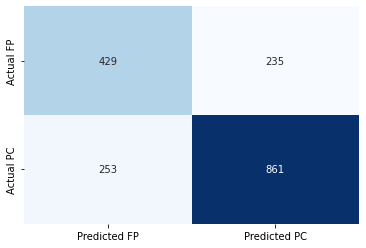

True Negatives (TN): 429
False Positives (FP): 235
False Negatives (FN): 253
True Positives (TP): 861
Recall: 0.7729
Precision: 0.7856
F1 Score: 0.7792
Accuracy: 0.7255


In [64]:
toi_data_cleaned['Prediction_no_ksmet'] = predictions
y_true = toi_data_cleaned['tfopwg_disp'].map({'CP': 1, 'KP': 1, 'FP': 0, 'FA': 0}).dropna().astype(int)
y_pred = toi_data_cleaned.loc[y_true.index, 'Prediction_no_ksmet'].astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted FP', 'Predicted PC'], yticklabels=['Actual FP', 'Actual PC'], cbar=False)
plt.savefig('figures/confusion_matrix.pdf', bbox_inches='tight')
plt.show()

# print confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# print classification metrics
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

In [66]:
summary_table_no_ksmet = pd.DataFrame(index=['CP', 'KP', 'FP', 'FA', 'PC', 'APC'],
                            columns=['Total TOIs', 'Predicted 1', 'Predicted 0', 'Accuracy %'])
for category in summary_table_no_ksmet.index:
    category_data = toi_data_cleaned[toi_data_cleaned['tfopwg_disp'] == category]
    total = len(category_data)
    pred_1 = np.sum(category_data['Prediction_no_ksmet'] == 1)
    pred_0 = np.sum(category_data['Prediction_no_ksmet'] == 0)
    if category in ['FP', 'FA']:
        accuracy_cat = (pred_0 / total * 100) if total > 0 else 0
    else:
        accuracy_cat = (pred_1 / total * 100) if total > 0 else 0
    summary_table_no_ksmet.loc[category] = [total, pred_1, pred_0, f"{accuracy_cat:.2f}"]
print("\nSummary Table:")
print(summary_table_no_ksmet)


Summary Table:
    Total TOIs Predicted 1 Predicted 0 Accuracy %
CP         591         505          86      85.45
KP         523         356         167      68.07
FP         620         210         410      66.13
FA          44          25          19      43.18
PC        3145        2273         872      72.27
APC        191          81         110      42.41


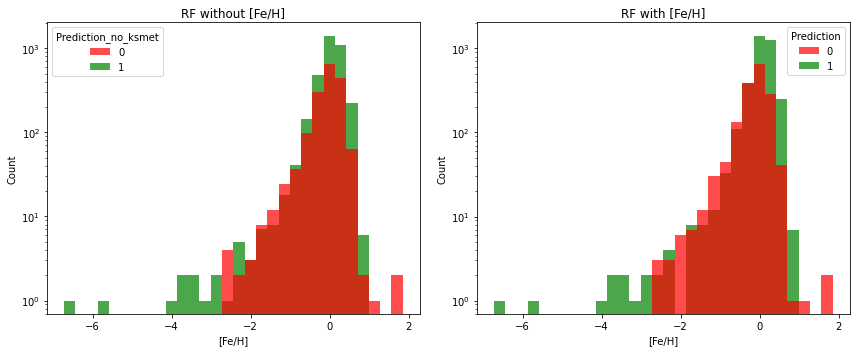

In [78]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(
    data=toi_data_cleaned, x='fe_h', hue='Prediction_no_ksmet',
    bins=30, palette={0: 'red', 1: 'green'}, alpha=0.7, edgecolor=None,
    hue_order=[0, 1]
)
plt.title('RF without [Fe/H]')
plt.xlabel('[Fe/H]')
plt.ylabel('Count')
plt.yscale('log')

plt.subplot(1, 2, 2)
sns.histplot(
    data=toi_data_cleaned, x='fe_h', hue='Prediction', bins=30, palette={0: 'red', 1: 'green'}, alpha=0.7, edgecolor=None,
    hue_order=[0, 1]
)
plt.title('RF with [Fe/H]')
plt.xlabel('[Fe/H]')
plt.ylabel('Count')
plt.tight_layout()
plt.yscale('log')
plt.show()


# From now on is Sarah's code

In [44]:
# Create a summary table
summary_table = pd.DataFrame(index=['CP', 'KP', 'FP', 'FA'], 
                            columns=['Total TOIs', 'Predicted 1', 'Predicted 0', 'Accuracy %'])
# Calculate counts for each category
for category in summary_table.index:
    total = len(toi_data_cleaned[toi_data_cleaned['tfopwg_disp'] == category])
    pred_1 = len(toi_data_cleaned[(toi_data_cleaned['tfopwg_disp'] == category) & 
                                (toi_data_cleaned['Prediction'] == 1)])
    pred_0 = len(toi_data_cleaned[(toi_data_cleaned['tfopwg_disp'] == category) & 
                                (toi_data_cleaned['Prediction'] == 0)])
    
    summary_table.loc[category, 'Total TOIs'] = total
    summary_table.loc[category, 'Predicted 1'] = pred_1
    summary_table.loc[category, 'Predicted 0'] = pred_0
    
    # Calculate accuracy differently for planet vs non-planet categories
    if category in ['CP', 'KP']:
        accuracy = pred_1 / total if total > 0 else 0
    else:  # FP and FA
        accuracy = pred_0 / total if total > 0 else 0
    
    summary_table.loc[category, 'Accuracy %'] = accuracy * 100  # Convert to percentage

# Format the table for better display
styled_table = (summary_table.style
                .format({
                    'Total TOIs': '{:.0f}',
                    'Predicted 1': '{:.0f}',
                    'Predicted 0': '{:.0f}',
                    'Accuracy %': '{:.2f}%'
                })
                .set_caption('Classification Performance by TOI Category')
                .set_table_styles([{
                    'selector': 'caption',
                    'props': [('font-size', '14pt'), ('font-weight', 'bold')]
                }])
                .background_gradient(cmap='Blues', subset=['Accuracy %'])
                .highlight_max(subset=['Accuracy %'], color='lightgreen')
                .highlight_min(subset=['Accuracy %'], color='#ffcccb'))

# Display the table
display(styled_table)

# Save the table to CSV
summary_table.to_csv('toi_classification_summary.csv')

# Print interpretation
print("\nInterpretation:")
print("- For CP/KP (planets), Accuracy % = % predicted as planets (1)")
print("- For FP/FA (false positives), Accuracy % = % predicted as non-planets (0)")

,Total TOIs,Predicted 1,Predicted 0,Accuracy %
CP,591,518,73,87.65%
KP,523,356,167,68.07%
FP,620,223,397,64.03%
FA,44,26,18,40.91%



Interpretation:
- For CP/KP (planets), Accuracy % = % predicted as planets (1)
- For FP/FA (false positives), Accuracy % = % predicted as non-planets (0)


STEP 2 Performance Evaluation vs. Disposition Category (CP, KP, FP FA)


Classification Performance Report

Confusion Matrix Components:
True Positives (TP): 883
True Negatives (TN): 436
False Positives (FP): 254
False Negatives (FN): 244

Performance Metrics:
Accuracy: 0.7259
Precision: 0.7766
Recall/Sensitivity: 0.7835
F1 Score: 0.7800


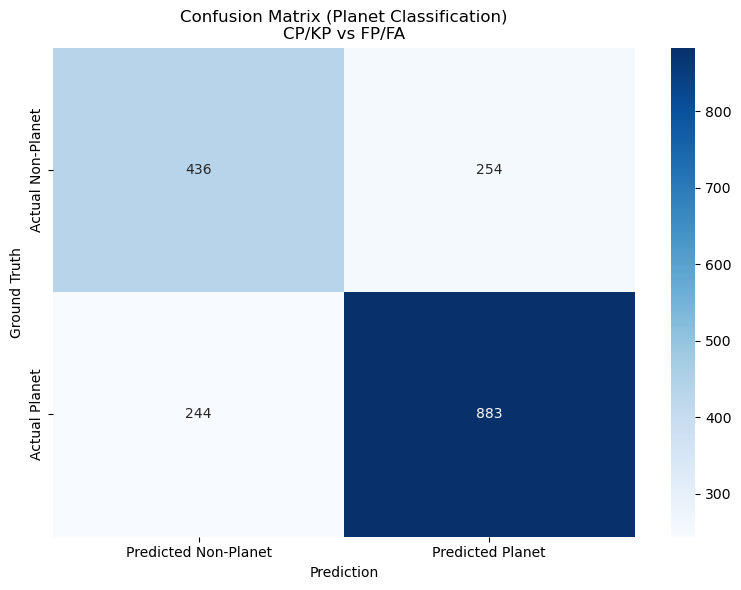

In [9]:
# First ensure we have clean data (no NaNs and only expected categories)
valid_categories = ['CP', 'KP', 'FP', 'FA']
toi_data_cleaned = toi_data_cleaned[
    toi_data_cleaned['tfopwg_disp'].isin(valid_categories) & 
    toi_data_cleaned['Prediction'].notna()
].copy()

# Calculate confusion matrix components with all categories
tp = len(toi_data_cleaned[
    (toi_data_cleaned['Prediction'] == 1) & 
    (toi_data_cleaned['tfopwg_disp'].isin(['CP', 'KP']))
])
tn = len(toi_data_cleaned[
    (toi_data_cleaned['Prediction'] == 0) & 
    (toi_data_cleaned['tfopwg_disp'].isin(['FP', 'FA']))
])
fp = len(toi_data_cleaned[
    (toi_data_cleaned['Prediction'] == 1) & 
    (toi_data_cleaned['tfopwg_disp'].isin(['FP', 'FA']))
])
fn = len(toi_data_cleaned[
    (toi_data_cleaned['Prediction'] == 0) & 
    (toi_data_cleaned['tfopwg_disp'].isin(['CP', 'KP']))
])

# Calculate performance metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print comprehensive report
print("\n" + "="*50)
print("Classification Performance Report")
print("="*50)
print(f"\nConfusion Matrix Components:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print(f"\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("="*50)

# Create visual confusion matrix
conf_matrix = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Planet', 'Predicted Planet'],
            yticklabels=['Actual Non-Planet', 'Actual Planet'])
plt.title('Confusion Matrix (Planet Classification)\nCP/KP vs FP/FA')
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.tight_layout()
plt.savefig('confusion_matrix_4_Disposition.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
STEP 3 Performance Evaluation vs. Disposition Category (CP, FP only)


Classification Performance Report

Confusion Matrix Components:
True Positives (TP): 537
True Negatives (TN): 418
False Positives (FP): 223
False Negatives (FN): 67

Performance Metrics:
Accuracy: 0.7671
Precision: 0.7066
Recall/Sensitivity: 0.8891
F1 Score: 0.7874


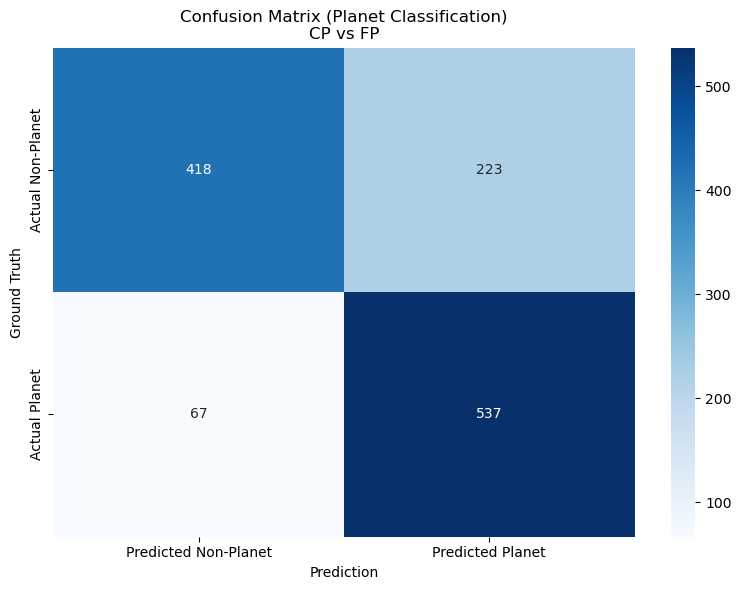

In [10]:
# First ensure we have clean data (no NaNs and only expected categories)
valid_categories = ['CP', 'KP', 'FP', 'FA']
toi_data_cleaned = toi_data_cleaned[
    toi_data_cleaned['tfopwg_disp'].isin(valid_categories) & 
    toi_data_cleaned['Prediction'].notna()
].copy()

# Calculate confusion matrix components with all categories
tp = len(toi_data_cleaned[
    (toi_data_cleaned['Prediction'] == 1) & 
    (toi_data_cleaned['tfopwg_disp'].isin(['CP']))
])
tn = len(toi_data_cleaned[
    (toi_data_cleaned['Prediction'] == 0) & 
    (toi_data_cleaned['tfopwg_disp'].isin(['FP']))
])
fp = len(toi_data_cleaned[
    (toi_data_cleaned['Prediction'] == 1) & 
    (toi_data_cleaned['tfopwg_disp'].isin(['FP']))
])
fn = len(toi_data_cleaned[
    (toi_data_cleaned['Prediction'] == 0) & 
    (toi_data_cleaned['tfopwg_disp'].isin(['CP']))
])

# Calculate performance metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print comprehensive report
print("\n" + "="*50)
print("Classification Performance Report")
print("="*50)
print(f"\nConfusion Matrix Components:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

print(f"\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("="*50)

# Create visual confusion matrix
conf_matrix = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Planet', 'Predicted Planet'],
            yticklabels=['Actual Non-Planet', 'Actual Planet'])
plt.title('Confusion Matrix (Planet Classification)\nCP vs FP')
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.tight_layout()
plt.savefig('confusion_matrix_2_Disposition.png', dpi=300, bbox_inches='tight')
plt.show()